<a href="https://colab.research.google.com/github/csabi0312/Sentiment-Analysis-of-IMDB-Movie-Ratings-with-LSTM-using-Keras-Tuner-/blob/main/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, LSTM, Bidirectional
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

from kerastuner.tuners import RandomSearch

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Data

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/DataScience/Sentiment_analysis/IMDB Dataset.csv')
df["sentiment"]=df.sentiment.apply(lambda x: int(x=='positive'))

In [ ]:
train, test, y_train, y_test = train_test_split(df["review"],df["sentiment"],test_size=0.3)
print(len(train),len(y_train),len(test),len(y_test))

35000 35000 15000 15000


In [ ]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [ ]:
tokenizer=Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train)

X_train = tokenizer.texts_to_sequences(train)
X_train = np.array(pad_sequences(X_train,maxlen=max_length, padding=padding_type, truncating=trunc_type))

X_test = tokenizer.texts_to_sequences(test)
X_test = np.array(pad_sequences(X_test,maxlen=max_length, padding=padding_type, truncating=trunc_type))

# Model

In [ ]:
def build_model(hp):
    model = Sequential()

    #Embedding layer
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))

    # Tune the number of hidden layers
    for i in range(hp.Int('num_layers', 0, 2)):
        # Tune the number of units in each hidden layer
        model.add(Bidirectional(LSTM(units=hp.Int('units_' + str(i), min_value=16, max_value=128, step=8), return_sequences=True)))
    
    model.add(Bidirectional(LSTM(units=hp.Int('units_2', min_value=16, max_value=128, step=8))))

    model.add(Dense(units=hp.Int('units_3', min_value=16, max_value=128, step=8),activation="relu"))

    # Add the output layer
    model.add(Dense(1, activation='sigmoid'))

    # Tune the learning rate of the optimizer
    lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=["accuracy"])

    return model

In [ ]:
# Define the Keras Tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True)

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=10, validation_split=0.2)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 04m 03s]
val_accuracy: 0.829714298248291

Best val_accuracy So Far: 0.8339999914169312
Total elapsed time: 00h 30m 06s


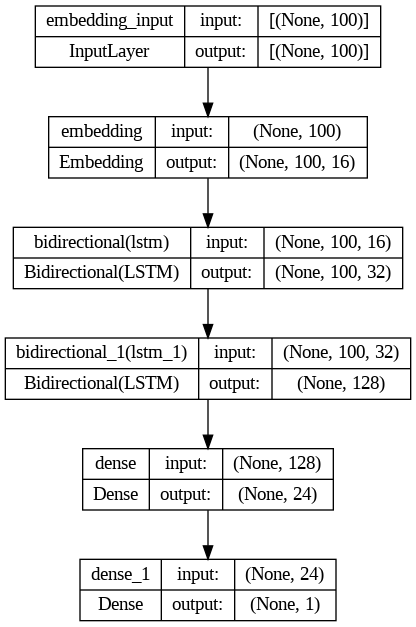

In [ ]:
plot_model(best_model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[EarlyStopping(patience=15)])

Epoch 1/50
875/875 [==============================] - 39s 38ms/step - loss: 0.1640 - accuracy: 0.9366 - val_loss: 0.5318 - val_accuracy: 0.8264
Epoch 2/50
875/875 [==============================] - 17s 20ms/step - loss: 0.1162 - accuracy: 0.9578 - val_loss: 0.5201 - val_accuracy: 0.8233
Epoch 3/50
875/875 [==============================] - 15s 18ms/step - loss: 0.0853 - accuracy: 0.9702 - val_loss: 0.6295 - val_accuracy: 0.8161
Epoch 4/50
875/875 [==============================] - 15s 17ms/step - loss: 0.0679 - accuracy: 0.9758 - val_loss: 0.7238 - val_accuracy: 0.8159
Epoch 5/50
875/875 [==============================] - 16s 18ms/step - loss: 0.0493 - accuracy: 0.9818 - val_loss: 0.8582 - val_accuracy: 0.8087
Epoch 6/50
875/875 [==============================] - 15s 17ms/step - loss: 0.0397 - accuracy: 0.9866 - val_loss: 1.0932 - val_accuracy: 0.8174
Epoch 7/50
875/875 [==============================] - 15s 17ms/step - loss: 0.0379 - accuracy: 0.9872 - val_loss: 0.8324 - val_accuracy:

In [ ]:
y_pred=(best_model.predict(X_test)>=0.5).astype(int)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

469/469 [==============================] - 5s 7ms/step
              precision    recall  f1-score   support

           0       0.81      0.82      0.82      7541
           1       0.82      0.80      0.81      7459

    accuracy                           0.81     15000
   macro avg       0.81      0.81      0.81     15000
weighted avg       0.81      0.81      0.81     15000

[[6201 1340]
 [1464 5995]]
